In [1]:
import vae
import torch
from vae import TimeseriesDataset, VAE, VAEExplainer, findThreshold
from transformers import TransformerModel, train, TransformerExplainer
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import shap
from torch import nn
import matplotlib.pyplot as plt
from captum.attr import KernelShap, DeepLift, DeepLiftShap
import csv
import os
from tempdata import massLoadData
from tqdm import tqdm

shap.initjs()

![Current Transformer-VAE network](transfomer.png)

# Toy example: Made up data

# Load up the data

In [2]:
data = range(30)
data = [[list(data)]] # serrated shape
print(data)

data2 = [1]*30
data2 = [[data2]] # uniform
print(data2)

transform = lambda x: torch.tensor(x).float()
train_dataset = TimeseriesDataset(data, transform)
train_dataloader = DataLoader(train_dataset, batch_size=1)

test_dataset = TimeseriesDataset(data2, transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]]
[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]


# Train the model on normal data

In [3]:
seq_len=1
transformer = TransformerModel(seq_len=seq_len)
train(transformer, seq_len, loaders={'train': train_dataloader}, epochs=40, phases=["train"])

100%|██████████| 40/40 [00:01<00:00, 37.25it/s]


In [4]:
mask = transformer.generate_square_subsequent_mask(seq_len)
tar_mask = transformer.generate_square_subsequent_mask(seq_len+1)
transformer(transform(data), mask, tar_mask)

tensor(0.0397, grad_fn=<MseLossBackward>)

# Test the model on faulty data

In [5]:
transformer(next(iter(test_dataloader)), mask, tar_mask)

tensor(0.5537, grad_fn=<MseLossBackward>)

# Explain the fault

In [6]:
normal_data = next(iter(train_dataloader))
fault_data = next(iter(test_dataloader))

explainer = VAEExplainer(lambda x: transformer(x, mask, tar_mask), [str(x) for x in range(30)], n_features=30)
explainer.shap(fault_data, normal_data)

tensor([[[ 0.0013,  0.0019, -0.0225, -0.0053, -0.0303, -0.0151, -0.0159,
          -0.0191, -0.0218, -0.0095, -0.0201, -0.0153, -0.0025,  0.0001,
          -0.0165,  0.0160,  0.0260,  0.0132,  0.0102,  0.0183,  0.0110,
           0.0349,  0.0473,  0.0608,  0.0671,  0.0811,  0.1088,  0.1160,
           0.1143,  0.1234]]])

## Visualize in force plot

In [7]:
shap_values, data, data_names = explainer.viz()
shap.force_plot(0, shap_values, data, data_names)

## Visualize as waterfall

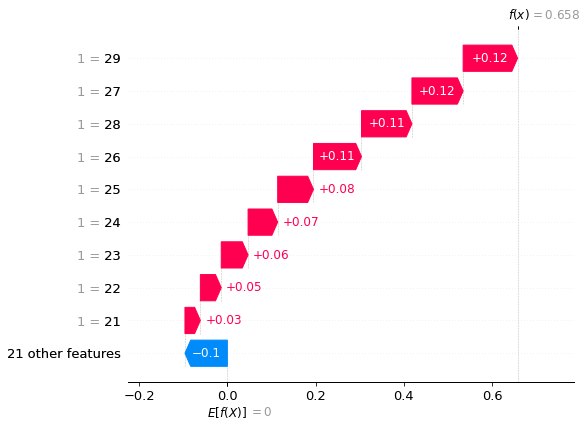

In [8]:
e = shap.Explanation(shap_values, base_values=0, data=data, feature_names=[str(d) for d in data_names])
shap.waterfall_plot(e)

# Better example: Simulated data

# Load the data

In [9]:
basePath = os.path.dirname('/Users/gabriel/Desktop/NASA/RAISR-2.0/src/data_driven_components')
headers, data = massLoadData(os.path.join(basePath, "data/data_physics_generation/No_Errors/"), 5)
data = np.array(data)
data = data[:,:,1:8].astype(np.float)
data = torch.tensor(data)
data = data.float()
headers = headers[1:8]

In [10]:
transform = lambda x: x.float()
train_dataset = TimeseriesDataset(data)
train_dataloader = DataLoader(train_dataset, batch_size=100)

# Create network

In [12]:
transformer = TransformerModel(input_dim=7, seq_len=5, att_heads=1, z_units=3)
print(transformer)

TransformerModel(
  (norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=100, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=100, out_features=7, bias=True)
        (norm1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=7, out_

# Train network

In [15]:
train(transformer, 5, {'train': train_dataloader}, epochs=2, phases=["train"])

100%|██████████| 2/2 [00:17<00:00,  8.79s/it]


# Learned representation

In [17]:
print(transformer.mu[0], transformer.logvar[0])

tensor([[-11.8072,  15.1481,  29.4396],
        [-12.8422,  15.7375,  30.2723],
        [ -9.6775,  14.9070,  28.2697],
        [-10.3172,  15.5035,  28.9119],
        [-14.3192,  15.2176,  29.7743],
        [ -6.1839,  15.3818,  26.7768],
        [-12.5609,  15.5392,  30.0077],
        [ -8.8717,  14.1236,  27.5192],
        [ -9.5429,  14.8149,  28.1292],
        [-11.7786,  14.9645,  29.2748],
        [-11.2096,  14.3628,  28.7881],
        [ -8.2159,  15.3524,  27.6092],
        [-12.5447,  15.8958,  29.9455],
        [-12.2533,  17.0259,  30.7103],
        [ -9.6459,  14.7150,  28.3036],
        [-12.9331,  16.1901,  29.1376],
        [-13.8147,  13.2197,  27.6553],
        [-11.2236,  16.1295,  29.4218],
        [ -9.6646,  14.8177,  28.1631],
        [-12.0471,  15.2411,  29.5954],
        [-10.2413,  15.2352,  27.1733],
        [-11.5255,  14.8224,  28.8605],
        [-10.1697,  15.6597,  28.5901],
        [-12.4692,  15.6414,  29.9509],
        [-14.2808,  15.4402,  29.6730],


# Load testing data

In [18]:
basePath = os.path.dirname('/Users/gabriel/Desktop/NASA/RAISR-2.0/src/data_driven_components')
headers, data2 = massLoadData(os.path.join(basePath, "data/data_physics_generation/crash/"), 5)
data2 = np.array(data2)
data2 = data2[:,:,1:8].astype(np.float)
data2 = torch.tensor(data2)
data2 = data2.float()
headers = headers[1:8]

In [19]:
transform = lambda x: x.float()
test_dataset = TimeseriesDataset(data2)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# Find fault threshold

In [33]:
mask = transformer.generate_square_subsequent_mask(5)
tar_mask = transformer.generate_square_subsequent_mask(6)
fault_threshold = findThreshold(lambda x: transformer(x, mask, tar_mask), train_dataset[0:10000], 2)
print(fault_threshold)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0026, grad_fn=<MulBackward0>)


# Find faults

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


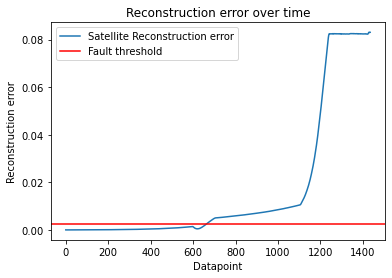

In [34]:
recon = []
for d in test_dataloader:
    recon.append(transformer(d, mask, tar_mask))

fig, ax = plt.subplots()
ax.set(xlabel='Datapoint', ylabel='Reconstruction error', title='Reconstruction error over time')
ax.plot(recon)
ax.axhline(fault_threshold, color="r")
ax.legend(['Satellite Reconstruction error', 'Fault threshold'])
fig.show()

# Diagnose faults

In [35]:
for idx, d in enumerate(test_dataloader):
    if idx == 400:
        normal_data = d
    if idx == 1100:
        fault_data = d

In [36]:
explainer = VAEExplainer(lambda x: transformer(x, mask, tar_mask), headers, n_features=7, seq_len=5)
shap_values = explainer.shap(fault_data, normal_data)

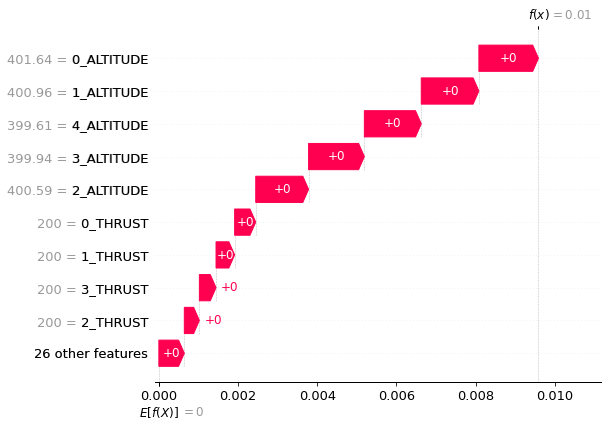

In [37]:
shap_values, data, data_names = explainer.viz(False)
e = shap.Explanation(shap_values, base_values=0, data=data, feature_names=data_names)
shap.waterfall_plot(e)

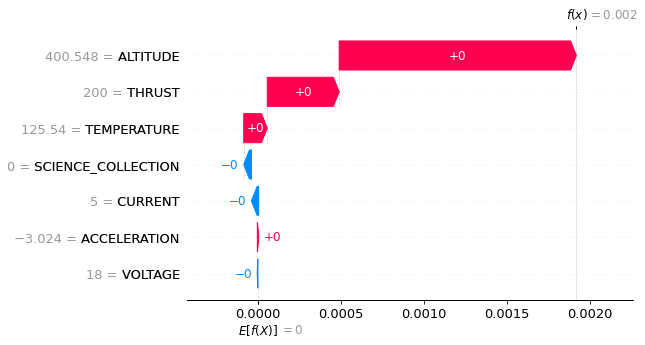

In [38]:
shap_values, data, data_names = explainer.viz(True)
e = shap.Explanation(shap_values, base_values=0, data=data, feature_names=data_names)
shap.waterfall_plot(e)

In [39]:
shap_values, data, data_names = explainer.viz(True)
shap.force_plot(0, shap_values, data, data_names)

In [40]:
shap_values, data, data_names = explainer.viz(False)
shap.force_plot(0, shap_values, data, data_names)

# Misc

In [ ]:
train(vae, {'train': train_dataloader}, epochs=2, lr=1e-3, phases=["train"], checkpoint=True)

In [ ]:
d = next(iter(train_dataloader))
print(vae(d))

In [ ]:
basePath = os.path.dirname('/Users/gabriel/Desktop/NASA/RAISR-2.0/src/data_driven_components')
headers, data2 = massLoadData(os.path.join(basePath, "data/data_physics_generation/crash/"), 1)
data2 = np.array(data2)
data2 = data2[:,:,1:8].astype(np.float)
data2 = torch.tensor(data2)
data2 = data2.float()
headers = headers[1:8]

In [ ]:
transform = lambda x: x.float()
test_dataset = TimeseriesDataset(data2)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
idx = 403

print(vae(train_dataset[idx].reshape(1,5,7)))
print(vae(test_dataset[idx].reshape(1,5,7)))
print(headers)
test_dataset[idx]

In [ ]:
findThreshold(vae, train_dataset, 0.5)

In [ ]:
def cleanUpData(data):
    

In [ ]:
def showReconstruction(dataset, fault_threshold):


In [ ]:
for idx, d in enumerate(test_dataloader):
    if((out := vae(d)) > 1e-1):
        print(idx, out)

In [ ]:
def makeHeaders(headers, seq_len):
    """
    Make sequential headers from 
    """
    long_header = []
    for t in range(seq_len):
        long_header += [str(t) + '_' + h for h in headers]
    return long_header

In [ ]:
b_h = makeHeaders(headers, 5)

In [ ]:
test_dataloader2 = DataLoader(test_dataset, batch_size=1)

In [ ]:
print(data)
data.reshape((5,7)).sum(axis=0)/5

In [ ]:
g = iter(test_dataloader)
normal_data = g.next()
fault_data = g.next()

explainer = VAEExplainer(vae, n_features=7)
explainer.shap(fault_data, normal_data)

shap_values, data, data_names = explainer.viz()
print(shap_values, data, headers)
shap_values[0] = 1
e = shap.Explanation(shap_values, base_values=0, data=data, feature_names=headers)
shap.waterfall_plot(e)

In [ ]:
data = range(30)
data = [[list(data)]] # serrated shape

data2 = [1]*30
data2 = [[data2]] # uniform

transform = lambda x: torch.tensor(x).float()
train_dataset = TimeseriesDataset(data, transform)
train_dataloader = DataLoader(train_dataset, batch_size=1)

test_dataset = TimeseriesDataset(data2, transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

print("Creating VAE...")
vae = VAE(input_dim=30, seq_len=1, z_units=5)
print("Successfuly created VAE")

In [ ]:
explainer = KernelShap(vae)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-1)

for x in train_dataloader:
    normal_data = x

vae.train(True)
for i in range(500):
        vae(fault_data)
        loss = vae.loss()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print(vae(normal_data))

In [ ]:
vae.train(False)
for x in test_dataloader:
    fault_data = x

"""
fault_data_recon = vae(fault_data)
recon_err = torch.linalg.norm(fault_data - fault_data_recon, axis=1) # different then loss, no kl divergence
fault_data_recon_abs = torch.abs(fault_data_recon)
values, indices = torch.topk(fault_data_recon_abs, 5)

print(values, indices)

for feature_idx in indices[0][0]:
    feature_idx = int(feature_idx)
    weight_save = vae.enc1.weight_ih_l0.clone()

    # Remove marginal contribution of feature_idx to vae
    vae.enc1.weight_ih_l0[:, feature_idx] = 0
    explainer = KernelShap(vae)
    shap_values = explainer.attribute(fault_data, baselines=normal_data, target=(0,feature_idx))
    vae.enc1.weight_ih_l0 = nn.Parameter(weight_save)
    print(shap_values[0, 0, indices])

recon_contribution = recon_err
print(recon_contribution)
"""
#shap.KernelExplainer(vae, normal_data)
shap_values = explainer.attribute(normal_data, fault_data, n_samples=200)
print(shap_values)
print(vae(fault_data))
shap_values = shap_values.detach().numpy().reshape((30))
data = fault_data.detach().numpy().reshape((30))
shap.force_plot(0, shap_values, data, list(range(30)))

In [ ]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm = nn.LSTM(
                    input_size=5,
                    hidden_size=5,
                    num_layers=1,
                    batch_first=True
                )
        self.loss_fn = nn.L1Loss()
    def forward(self, x):
        self.input = x
        self.output, _ = self.lstm(x)
        return self.output
    def loss(self):
        return self.loss_fn(self.input, self.output)

def scale_down(x):
    return (x-2.5)*(1/5)

def scale_up(x):
    return x*5+2.5

In [ ]:
data = [[[1]+[5]*4],[[2]+[5]*4],[[3]+[5]*4],[[4]+[5]*4],[[5]+[5]*4]]

toy_lstm = lstm()

transform = lambda x: scale_down(torch.tensor(x).float())
dataset = TimeseriesDataset(data, transform)
dataloader = DataLoader(dataset, batch_size=1)

optimizer_lstm = torch.optim.Adam(toy_lstm.parameters(), lr=1e-2)

losses = []
toy_lstm.train(True)
for i in range(50):
    for d in dataloader:
        x = d
        out = toy_lstm(d)
        loss = toy_lstm.loss()
        losses.append(loss)
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
datum = torch.tensor([[range(5)]], dtype=torch.float)
datum = scale_down(datum)
prezero = toy_lstm(datum)
for w in toy_lstm.parameters():
    print(w.shape)

weight_save = toy_lstm.lstm.weight_ih_l0.clone()
toy_lstm.lstm.weight_ih_l0[:,0] = 0
postzero = toy_lstm(datum)
prezero = scale_up(prezero)
postzero = scale_up(postzero)
print(prezero, '\n', postzero, '\n', prezero-postzero)
toy_lstm.lstm.weight_ih_l0 = nn.Parameter(weight_save)

In [ ]:
x = torch.tensor([[[5,5]]]).float()
out = toy_lstm(x)
print(x, out)
print(x-out)

In [ ]:
lstm_1 = nn.LSTM(3, 3)

in_tensor = torch.Tensor([[-1,0,1]]).reshape(1,1,3)

optimizer = torch.optim.Adagrad(lstm_1.parameters(), lr=2e-1, lr_decay=0.02)
loss_fn = nn.MSELoss()


losses = []
for i in range(400):
    pred_out = lstm_1(in_tensor)[0]
    optimizer.zero_grad()
    loss = loss_fn(pred_out, in_tensor)
    losses.append(loss)
    loss.backward()
    optimizer.step()

plt.plot(losses)
plt.show()


In [ ]:
print(in_tensor.shape)
print(lstm_1(in_tensor)[0])